# Assay Annotations
This notebook compares the sets of assays between badapple_classic and badapple2.

# Setup

In [83]:
# define DB variables
ORIGINAL_DB_NAME = "badapple_classic"
ORIGINAL_DB_HOST = "localhost"
ORIGINAL_DB_USER = "<your_usr>"
ORIGINAL_DB_PASSWORD = "<your_pw>"

COMPARISON_DB_NAME = "badapple2"
COMPARISON_DB_HOST = ORIGINAL_DB_HOST
COMPARISON_DB_USER = ORIGINAL_DB_USER
COMPARISON_DB_PASSWORD = ORIGINAL_DB_PASSWORD

In [84]:
# list of AIDs from ORIGINAL_DB
ORIGINAL_AID_PATH = "/media/jack/big_disk/data/badapple/badapple1_inputs/badapple_classic_tested.aid"
# list of AIDs from COMPARISON_DB
COMPARISON_AID_PATH = "/media/jack/big_disk/data/badapple/badapple2/badapple2_tested.aid"

In [85]:
# imports
import psycopg2
import psycopg2.extras
from psycopg2 import sql
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

## Connect to DBs

In [86]:
def db_connect(db_name: str, host: str, user: str, password: str):
    try:
        db_connection = psycopg2.connect(
            dbname=db_name,
            host=host,
            user=user,
            password=password,
            cursor_factory=psycopg2.extras.DictCursor,
        )
        db_connection.set_session(readonly=True)
        return db_connection
    except Exception as e:
        print(e)
        print(f"Error connecting to DB: {db_name}")
        return None

In [87]:
original_db_connection = db_connect(ORIGINAL_DB_NAME, ORIGINAL_DB_HOST, ORIGINAL_DB_USER, ORIGINAL_DB_PASSWORD)
comparison_db_connection = db_connect(COMPARISON_DB_NAME, COMPARISON_DB_HOST, COMPARISON_DB_USER, COMPARISON_DB_PASSWORD)

In [88]:
original_db_cur = original_db_connection.cursor()
comparison_db_cur = comparison_db_connection.cursor()

## Read AID Files

In [89]:
def read_aid_file(aid_file_path: str) -> list[int]:
    with open(aid_file_path, "r") as file:
        aid_list = [int(line.strip()) for line in file if line.strip().isdigit()]
    return aid_list

In [90]:
ORIGINAL_AID_LIST = read_aid_file(ORIGINAL_AID_PATH)
COMPARISON_AID_LIST = read_aid_file(COMPARISON_AID_PATH)

In [91]:
print(len(set(ORIGINAL_AID_LIST)), len(set(COMPARISON_AID_LIST)))
print(len(set(ORIGINAL_AID_LIST) - set(COMPARISON_AID_LIST)))
print(len(set(COMPARISON_AID_LIST) - set(ORIGINAL_AID_LIST)))

823 906
0
83


# Fetch Assay Annotations
Annotations come from BARD.

In [92]:
ANN_COLUMNS = "aid,assay_format,assay_type,detection_method"
ANN_COLUMNS_LIST =  ANN_COLUMNS.split(",")

In [93]:
def get_assay_annotations(db_cursor, db_conn):
    query = sql.SQL(f"SELECT {ANN_COLUMNS} FROM aid2descriptors")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result
    except Exception:
        db_conn.rollback()
    return result

In [94]:
COMPARISON_ASSAY_ANNOTATIONS = get_assay_annotations(comparison_db_cur, comparison_db_connection)

In [95]:
comparison_ann_df = pd.DataFrame(COMPARISON_ASSAY_ANNOTATIONS, columns=ANN_COLUMNS_LIST)
comparison_ann_df

,aid,assay_format,assay_type,detection_method
0,360,protein format,direct enzyme activity assay,fluorescence intensity
1,361,biochemical format,direct enzyme activity assay,absorbance method
2,368,protein format,direct enzyme activity assay,fluorescence intensity
3,373,cell-based format,reporter-gene assay,fluorescence resonance energy transfer
4,374,cell-based format,direct enzyme activity assay,fluorescence intensity
...,...,...,...,...
901,1671463,None,None,None
902,1745845,None,None,None
903,1745853,None,None,None
904,1745857,None,None,None


In [96]:
original_ann_df = comparison_ann_df[comparison_ann_df["aid"].isin(ORIGINAL_AID_LIST)]
original_ann_df

,aid,assay_format,assay_type,detection_method
0,360,protein format,direct enzyme activity assay,fluorescence intensity
1,361,biochemical format,direct enzyme activity assay,absorbance method
2,368,protein format,direct enzyme activity assay,fluorescence intensity
3,373,cell-based format,reporter-gene assay,fluorescence resonance energy transfer
4,374,cell-based format,direct enzyme activity assay,fluorescence intensity
...,...,...,...,...
842,1053133,None,None,None
844,1053197,None,None,None
845,1117264,None,None,None
846,1117267,None,None,None


# Process Data

In [97]:
def get_frequency_df(d: dict[str, list[str]] | pd.DataFrame, key: str, remove_str: str = None) -> pd.DataFrame:
    term_counts = Counter(d[key])
    df = pd.DataFrame(term_counts.items(), columns=['Term', 'Frequency'])
    df = df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
    # map None to "NULL"
    df["Term"] = df["Term"].map(lambda x: "NULL" if x is None else x)
    if remove_str is not None:
        df["Term"] = df["Term"].map(lambda x: x.replace(remove_str, ''))
    return df

In [98]:
def get_high_frequency_df(df: pd.DataFrame, thresh: int, freq_col: str = "Frequency") -> pd.DataFrame:
    # group terms with frequencies <= thresh under "Other" category
    df_high_freq = df[df[freq_col] > thresh]
    other_freq_sum = df[df[freq_col] <= thresh][freq_col].sum()
    i = len(df_high_freq)
    df_high_freq.loc[i] = ['OTHER', other_freq_sum]
    df_high_freq = df_high_freq.sort_values(by=freq_col, ascending=False).reset_index(drop=True)
    return df_high_freq

# Create plots

In [99]:
def plot_frequency_comparison(df1: pd.DataFrame, df2: pd.DataFrame, df1_label: str, df2_label: str, title_key: str, yscale: str = "linear"):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(df1['Term'], df1["Frequency"], width=0.35, label=df1_label, color='skyblue', align="center")
    ax.bar(df2['Term'], df2["Frequency"], width=0.35/3, label=df2_label, color='orange', align="center")

    # Add labels and title
    ax.set_xlabel('Term')
    ax.set_yscale(yscale)
    ax.set_ylabel('Frequency')
    plt.title(f'Frequency of {title_key} Terms')
    ax.legend()
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Assay Format

In [100]:
remove_str = " format"
key = "assay_format"
title_key = "Assay Format"

In [101]:
df1 = get_frequency_df(original_ann_df, key, remove_str)
df2 = get_frequency_df(comparison_ann_df, key, remove_str)

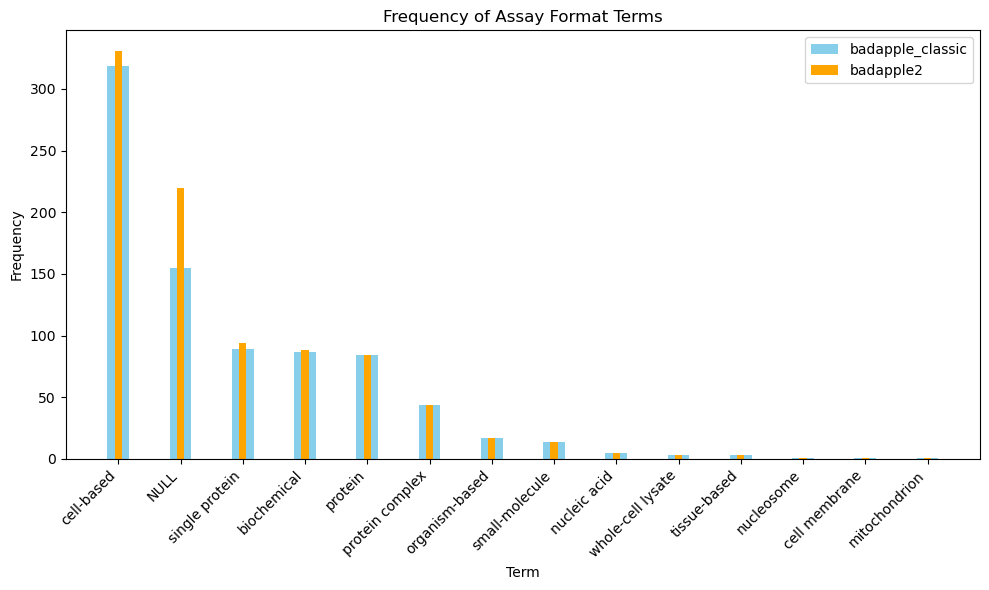

In [102]:
plot_frequency_comparison(df1, df2, ORIGINAL_DB_NAME, COMPARISON_DB_NAME, title_key)

## Assay Format

In [103]:
remove_str = " assay"
key = "assay_type"
title_key = "Assay Type"

In [104]:
df1 = get_frequency_df(original_ann_df, key, remove_str)
df2 = get_frequency_df(comparison_ann_df, key, remove_str)

In [105]:
df1 = get_high_frequency_df(df1, 2)
df2 = get_high_frequency_df(df2, 2)

/tmp/ipykernel_74007/2689725211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]
/tmp/ipykernel_74007/2689725211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]


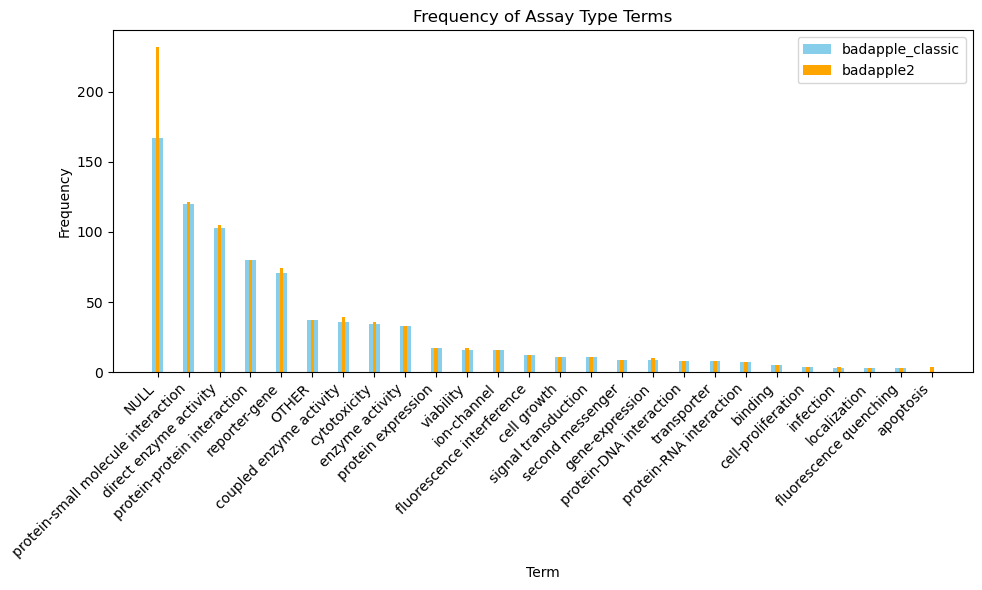

In [106]:
plot_frequency_comparison(df1, df2, ORIGINAL_DB_NAME, COMPARISON_DB_NAME, title_key)

## Detection Method

In [107]:
remove_str = " assay"
key = "detection_method"
title_key = "Detection Method"

In [108]:
df1 = get_frequency_df(original_ann_df, key, remove_str)
df2 = get_frequency_df(comparison_ann_df, key, remove_str)

In [109]:
df1 = get_high_frequency_df(df1, 2)
df2 = get_high_frequency_df(df2, 2)

/tmp/ipykernel_74007/2689725211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]
/tmp/ipykernel_74007/2689725211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]


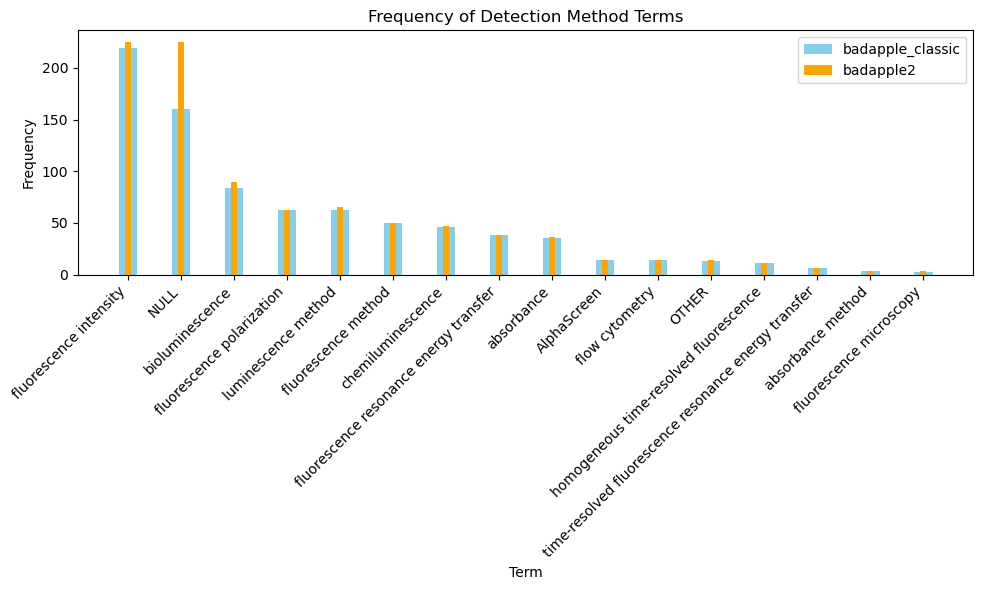

In [110]:
plot_frequency_comparison(df1, df2, ORIGINAL_DB_NAME, COMPARISON_DB_NAME, title_key)

# Close DB Connections

In [111]:
# Close the cursors
original_db_cur.close()
comparison_db_cur.close()

# Close the connections
original_db_connection.close()
comparison_db_connection.close()